# Importing all the packages needed

In [1]:
import numpy as np
import seaborn as sns
import rdkit
from rdkit import Chem 
from rdkit.Chem import Descriptors, Lipinski
import pandas as pd
from chembl_webresource_client.new_client import new_client

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, median_absolute_error, max_error
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from scipy.stats import randint, uniform
import matplotlib.pyplot as plt
import skorch
from skorch import NeuralNetClassifier

In [3]:
import torch # supprimable
import torch.nn as nn
import torch.optim as optim

# Choosing the what is our Target protein: mTor is a good candidate

In [4]:
target = new_client.target
target_query = target.search('mTOR')
possible_targets = pd.DataFrame.from_dict(target_query)
possible_targets.head()
target = possible_targets.target_chembl_id[3]

In [5]:
activity = new_client.activity
res = activity.filter(target_chembl_id=target).filter(standard_type="IC50")
df = pd.DataFrame.from_dict(res)


# Data cleaning & preparation

## Keeping only interesting entries for our models and suppression of incomplete data 

In [6]:
df_clean = data_cleaner(df)
df_clean

NameError: name 'data_cleaner' is not defined

## Labeling of the bioactivity of the different molecules

In [ ]:
df_label = add_bioactivity(df_clean)
df_label

## Definition of the Lipinski descriptor

In [ ]:
df_lipinski = lipinski_df(df_label)
df_lipinski

In [ ]:
plt.figure(figsize=(5.5, 5.5))
#sns.color_palette("flare")
sns.countplot(x='Bioactivity', hue = 'Bioactivity', data=df_lipinski, edgecolor='black', palette = "flare")

plt.xlabel('Bioactivity', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

descriptors = ['Mw', 'H donors', 'H acceptors', 'Log P']
sns.pairplot(df_lipinski[descriptors + ['Bioactivity']], hue="Bioactivity", palette = "flare")

It is visible that the inactive and partially active labeled molecule share a huge overlap, using the Lipinski descriptors may not offer the best features to separate them.

The number of Lipinski descriptors is limited and so even if we began with them, we decided to the rdkit package and its descriptors which are more than 200

## Definition of the rdkit descriptor

In [ ]:
df_descriptor = descriptor_df(df_label)

In [ ]:
df_descriptor

# Data preparation for the models:

In [ ]:
X_train, X_test, Y_train, Y_test= data_prep(df_descriptor)

np.random.seed(100) 

# Model Construction and Optimization

## Classification model

### Optimization of the Full-Connected Neural Network

Test Accuracy: 0.8441273326015367
Test Precision: 0.8372063033984013
Test Recall: 0.8441273326015367
Test F1 Score: 0.8402229693005815
Confusion Matrix:
 [[ 67  20  16]
 [ 21  56  43]
 [ 14  28 646]]
Classification Report:
               precision    recall  f1-score   support

          -1       0.66      0.65      0.65       103
           0       0.54      0.47      0.50       120
           1       0.92      0.94      0.93       688

    accuracy                           0.84       911
   macro avg       0.70      0.69      0.69       911
weighted avg       0.84      0.84      0.84       911



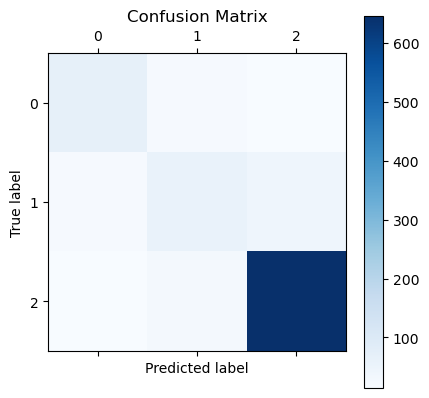

Best Hyperparameters for Feedforward Neural Network: {'activation': 'relu', 'alpha': 0.45055420204434604, 'learning_rate_init': 0.0023132311548267866}
Best Parameters {'activation': 'relu', 'alpha': 0.45055420204434604, 'learning_rate_init': 0.0023132311548267866} Test accuracy: 0.8441273326015367


In [36]:
best_params_fcn,test_accuracy_fcn = optimize_hyperparameters_random_search(df_descriptor, 'fcn')
print("Best Hyperparameters for Feedforward Neural Network:", best_params_fcn)
print("Best Parameters", best_params_fcn,"Test accuracy:",test_accuracy_fcn)

### Optimization of the RandomForest

Test Accuracy: 0.8375411635565313
Test Precision: 0.8260485432091725
Test Recall: 0.8375411635565313
Test F1 Score: 0.828329247296322
Confusion Matrix:
 [[ 81   9  45]
 [ 12  43  45]
 [ 12  25 639]]
Classification Report:
               precision    recall  f1-score   support

          -1       0.77      0.60      0.68       135
           0       0.56      0.43      0.49       100
           1       0.88      0.95      0.91       676

    accuracy                           0.84       911
   macro avg       0.74      0.66      0.69       911
weighted avg       0.83      0.84      0.83       911



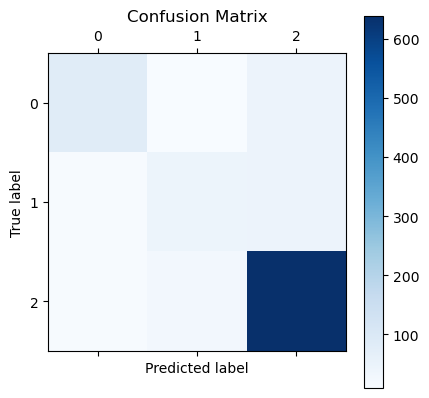

Best Hyperparameters for Feedforward Neural Network: {'max_depth': 48, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 406}
Best Parameters {'max_depth': 48, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 406} Test accuracy: 0.8375411635565313


In [37]:
best_params_rf,test_accuracy_rf = optimize_hyperparameters_random_search(df_descriptor, 'rf')
print("Best Hyperparameters for RF:", best_params_rf)
print("Best Parameters", best_params_rf,"Test accuracy:",test_accuracy_rf)

### Optimization of the Gradient Boosting

Test Accuracy: 0.8737650933040615
Test Precision: 0.8673019123410753
Test Recall: 0.8737650933040615
Test F1 Score: 0.8698531032237976
Confusion Matrix:
 [[ 74  14  21]
 [ 14  54  34]
 [ 11  21 668]]
Classification Report:
               precision    recall  f1-score   support

          -1       0.75      0.68      0.71       109
           0       0.61      0.53      0.57       102
           1       0.92      0.95      0.94       700

    accuracy                           0.87       911
   macro avg       0.76      0.72      0.74       911
weighted avg       0.87      0.87      0.87       911



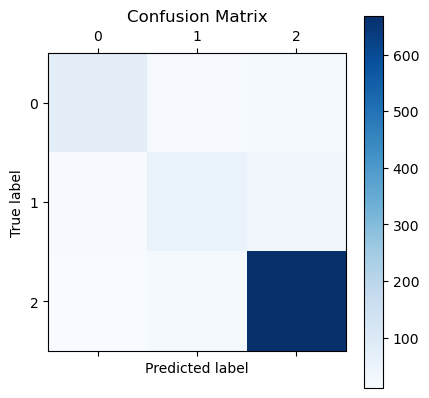

Best Hyperparameters for Feedforward Neural Network: {'learning_rate': 0.3290277424959528, 'max_depth': 6, 'min_samples_leaf': 7, 'min_samples_split': 10, 'n_estimators': 427}
Best Parameters {'learning_rate': 0.3290277424959528, 'max_depth': 6, 'min_samples_leaf': 7, 'min_samples_split': 10, 'n_estimators': 427} Test accuracy: 0.8737650933040615


In [38]:
best_params_gbm,test_accuracy_gbm = optimize_hyperparameters_random_search(df_descriptor, 'gbm')
print("Best Hyperparameters for GBM:", best_params_gbm)
print("Best Parameters", best_params_gbm,"Test accuracy:",test_accuracy_gbm)

# Construction of the Ensemble Model

In [ ]:
#rf_param = RandomForestClassifier(**best_params_rf)
#Best Parameters {'max_depth': 48, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 406} 
rf_param = {'max_depth': 48, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 406} 


#gbm_param = GradientBoostingClassifier(**best_params_gbm)
#Best Parameters {'learning_rate': 0.3290277424959528, 'max_depth': 6, 'min_samples_leaf': 7, 'min_samples_split': 10, 'n_estimators': 427}
gbm_param = {'learning_rate': 0.3290277424959528, 'max_depth': 6, 'min_samples_leaf': 7, 'min_samples_split': 10, 'n_estimators': 427}
#Test accuracy: 0.8737650933040615


#fcn_params = best_params_fcn
#Best Parameters {'activation': 'relu', 'alpha': 0.45055420204434604, 'learning_rate_init': 0.0023132311548267866} 
fcn_params = {'activation': 'relu', 'alpha': 0.45055420204434604, 'learning_rate_init': 0.0023132311548267866}
#Test accuracy: 0.8441273326015367

rf = RandomForestClassifier(**rf_param)
rf.fit(X_train, Y_train)
pred_rf = rf.predict_proba(X_test)[:, 1]

gbm = GradientBoostingClassifier(**gbm_param)
gbm.fit(X_train, Y_train)
pred_gbm = gbm.predict_proba(X_test)[:, 1]

activation_mapping = {
    'relu': nn.ReLU(),
}

class FCNN(nn.Module):
    def __init__(self, input_dim, activation):
        super(FCNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.activation = activation
    
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

net = NeuralNetClassifier(
    module=FCNN,
    module__input_dim=X_train.shape[1],
    module__activation=activation_mapping[fcn_params['activation']],
    max_epochs=50,
    lr=fcn_params['learning_rate_init'],
    batch_size=32,
    optimizer=optim.Adam,
    criterion=nn.BCELoss,
    iterator_train__shuffle=True,
    verbose=0
)

net.fit(X_train.astype(np.float32), Y_train.astype(np.int64))
pred_fcnn = net.predict_proba(X_test.astype(np.float32))[:, 1]

ensemble_pred = (pred_rf + pred_gbm + pred_fcnn) / 3
ensemble_pred_class = (ensemble_pred > 0.5).astype(int)

accuracy = accuracy_score(y, ensemble_pred_class)
print(f'Ensemble Model Accuracy: {accuracy:.2f}')


In [ ]:
#rf_param = RandomForestClassifier(**best_params_rf)
#Best Parameters {'max_depth': 48, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 406} 
rf_param = {'max_depth': 48, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 406} 

rf = RandomForestClassifier(**rf_param)
rf.fit(X_train, Y_train)
pred_rf = rf.predict(X_test)[:, 1]

In [ ]:
import numpy as np # Supprimable
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

cm = np.array([[74, 14, 21],
               [14, 54, 34],
               [11, 21, 668]])

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

cm_df = pd.DataFrame(cm_normalized, index=['Class 0', 'Class 1', 'Class 2'], columns=['Pred 0', 'Pred 1', 'Pred 2'])

plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, fmt='.2%', cmap='Blues')
plt.title('Confusion Matrix (Normalized by Rows)')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


## definition of the functions

In [ ]:
##### DEFINITION OF A FUNCTION ####

def data_cleaner(dataframe):
    """
    dataframe: dataframe of all the candidate proteins 

    The function only keep the entries of interest: 'molecule_chembl_id','canonical_smiles','standard_value'
    and also get rid of the incomplete data
    
    """ 
    dataframe = dataframe = dataframe[['molecule_chembl_id','canonical_smiles','standard_value']]
    dataframe_cleaned = dataframe[dataframe.standard_value.notna()]
    dataframe_cleaned = dataframe_cleaned[dataframe.canonical_smiles.notna()]
    dataframe_cleaned = dataframe_cleaned.drop_duplicates(['canonical_smiles'])
    
    return dataframe_cleaned

##### DEFINITION OF A FUNCTION ####

def add_bioactivity(dataframe):
    """
    dataframe: (cleaned) dataframe of all the candidate proteins 

    The function labels the molecules as inactive, partialy active or active depending on their standard value
    """ 
    bioactivity = []
    for i in dataframe.standard_value:
      if float(i) >= 10000:
        bioactivity.append(0) #inactive
      elif float(i) <= 1000:
        bioactivity.append(2) #active
      else:
        bioactivity.append(1) #depends
    dataframe['Bioactivity'] = bioactivity
    dataframe.reset_index(drop=True, inplace=True)
    return dataframe


##### DEFINITION OF A FUNCTION ####

def lipinski(smiles):
    """
    smile: smile (column) 

    The function calculate the Lipinski descriptors from the smiles, the Lipinski descriptors are the MW, the LogP (solubility),
    the number of H donors and the number of H acceptors
    
    """ 

    
    molec = []
    for i in smiles:
        mol = Chem.MolFromSmiles(i) 
        molec.append(mol)

    MW = []
    LogP = []
    NHDonors = []
    NHAcceptors = []

    for n in molec:        
        MW.append(Descriptors.MolWt(n))
        LogP.append(Descriptors.MolLogP(n))
        NHDonors.append(Lipinski.NumHDonors(n))
        NHAcceptors.append(Lipinski.NumHAcceptors(n))
        
    desc_data = pd.DataFrame({
        "Mw": MW,
        "H donors": NHDonors,
        "H acceptors": NHAcceptors,
        "Log P": LogP
    })
    
    return desc_data

def norm_value(input):
    """
    input: clean dataframe of the candidate molecules 

    The function cnormalize the standard value 
    
    """ 
    
    norm = []

    for i in input['standard_value']:
        if i > 100000000:
            i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop(columns=['standard_value'])  # Drop the 'standard_value' column

    return x

def pIC50(input):
    """
    input: clean dataframe of the candidate molecules 

    The function calculate and add the pIC50 (a measure of bioactivity)
    
    """ 
    
    if 'standard_value_norm' not in input.columns:
        raise ValueError("Column 'standard_value_norm' does not exist in the DataFrame.")

    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i * (10**-9)  # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop(columns=['standard_value_norm'])  # Drop the 'standard_value' column

    return x


def lipinski_df(dataframe):
    """
    dataframe: clean dataframe of the candidate molecules 

    The function calculate and add the the Lipinski descriptors, normalize the standard values and the pIC50
    
    """ 

    
    dataframe_lipinski = pd.concat([dataframe, lipinski(dataframe.canonical_smiles)], axis = 1)
    dataframe_lipinski['standard_value'] = pd.to_numeric(dataframe_lipinski['standard_value'], errors='coerce')
    dataframe_lipinski = dataframe_lipinski.loc[pd.notna(dataframe_lipinski['standard_value'])]
    dataframe_lipinski = norm_value(dataframe_lipinski)
    dataframe_lipinski = pIC50(dataframe_lipinski)

    return dataframe_lipinski

#### DEFINITION FUNCTION ####

def descriptors(smiles):
    """
    smile: smile (column) 

    The function calculate the rdkit descriptors from the smiles, the rdkit descriptors are composed of a lot of different descriptors
    
    """ 
    
    mols = []

    for i in smiles:
        molec = Chem.MolFromSmiles(i)
        mols.append(molec)
    descrs = [Descriptors.CalcMolDescriptors(mol) for mol in mols]
    df_descr = pd.DataFrame(descrs)

    return df_descr

def descriptor_df(dataframe):
    """
    dataframe: clean dataframe of the candidate molecules 

    The function calculate and add the the rdkit descriptors, normalize the standard values and the pIC50
    
    """ 


    
    dataframe_descriptors = pd.concat([dataframe, descriptors(dataframe.canonical_smiles)], axis = 1)
    dataframe_descriptors['standard_value'] = pd.to_numeric(dataframe_descriptors['standard_value'], errors='coerce')
    dataframe_descriptors = dataframe_descriptors.loc[pd.notna(dataframe_descriptors['standard_value'])]
    dataframe_descriptors = norm_value(dataframe_descriptors)
    dataframe_descriptors = pIC50(dataframe_descriptors)
    
    #dataframe_descriptors.replace([np.inf, -np.inf], np.nan, inplace=True)
    dataframe_descriptors.dropna(inplace=True)
    dataframe_descriptors.reset_index(drop=True, inplace=True)
    
    return dataframe_descriptors

#### DEFINITION FUNCTION ####

def data_prep(dataframe):
    
    dataframe = dataframe.drop('molecule_chembl_id', axis=1)
    #dataframe = dataframe.drop('Bioactivity', axis=1)
    dataframe = dataframe.drop('canonical_smiles', axis=1)

    selection = VarianceThreshold(threshold=(.9 * (1 - .3)))

    X = dataframe.drop('pIC50', axis=1)
    X = selection.fit_transform(X)
    Y = dataframe['Bioactivity']

    X_train, X_test, Y_train, Y_test = data_split_scale(X,Y)

    return X_train, X_test, Y_train, Y_test

def data_split_scale(X,Y):
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test, Y_train, Y_test

#### DEFINITION FUNCTION ####


def data_prep(dataframe):
    """
    dataframe: clean dataframe of the candidate molecules with the descriptors

    The function remove the 'molecule_chembl_id', 'pIC50' and 'canonical_smiles', it centers the labels around zero. It separates 
    the features in a 'X' matrix and the bioactivity label in a 'Y' vector. Also keep the features with a sufficient threshold and 
    then split the data into a training set and a test set.
    
    """ 

    
    dataframe = dataframe.drop('molecule_chembl_id', axis=1)
    dataframe = dataframe.drop('pIC50', axis=1)
    dataframe = dataframe.drop('canonical_smiles', axis=1)
    dataframe['Bioactivity'] = dataframe['Bioactivity'] - 1 


    selection = VarianceThreshold(threshold=(.9 * (1 - .3)))

    X = dataframe.drop('Bioactivity', axis=1)
    X = selection.fit_transform(X)
    Y = dataframe['Bioactivity']

    X_train, X_test, Y_train, Y_test = data_split_scale(X,Y)

    return X_train, X_test, Y_train, Y_test

def data_split_scale(X,Y):
    """
    X: features of the data
    Y: label of the data

    The function split the data into a test and a training set and scale the features on the training set.
    """
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test, Y_train, Y_test


def optimize_hyperparameters_random_search(dataframe, model_type):
    """
    dataframe: clean dataframe of the candidate molecules with the descriptors
    model_type: 'rf', 'gbm', or 'fcn'
    

    The function do the data preparation and then train the chosen model using a randomized search. The model is then evaluated 
    using the accuracy, the precision, the recall, the F1 Score and the confusion matrix.
    The best parameter found are then returned.
    """ 

    
    X_train, X_test, y_train, y_test = data_prep(dataframe)
    np.random.seed(100) 

    if model_type == 'rf':
        model = RandomForestClassifier()
        param_space = {
            'n_estimators': randint(100, 500),
            'max_depth': randint(5, 50),
            'min_samples_split': randint(2, 20),
            'min_samples_leaf': randint(1, 20),
        }
    elif model_type == 'gbm':
        model = GradientBoostingClassifier()
        param_space = {
            'n_estimators': randint(100, 500),
            'learning_rate': uniform(0.01, 0.49),
            'max_depth': randint(3, 10),
            'min_samples_split': randint(2, 20),
            'min_samples_leaf': randint(1, 20),
        }
    elif model_type == 'fcn':
        model = MLPClassifier(hidden_layer_sizes=(100,), solver='adam')
        param_space = {
            'activation': ['relu', 'tanh', 'logistic'],
            'alpha': uniform(0.0001, 0.9999),
            'learning_rate_init': uniform(0.001, 0.099),
        }
    else:
        raise ValueError("Invalid model_type. Choose 'rf', 'gbm', or 'fcn'.")

    opt = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_space,
        n_iter=25,
        cv=5,
        n_jobs=-1,
        scoring='accuracy',  # Optimize for accuracy
        verbose=0,
        random_state=42,
    )

    opt.fit(X_train, y_train)
    best_params = opt.best_params_
    best_model = opt.best_estimator_
    y_pred = best_model.predict(X_test)
    
    # Evaluate the model
    test_accuracy = accuracy_score(y_test, y_pred)
    test_precision = precision_score(y_test, y_pred, average='weighted')
    test_recall = recall_score(y_test, y_pred, average='weighted')
    test_f1 = f1_score(y_test, y_pred, average='weighted')

    print("Test Accuracy:", test_accuracy)
    print("Test Precision:", test_precision)
    print("Test Recall:", test_recall)
    print("Test F1 Score:", test_f1)
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.matshow(cm, cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    return best_params, test_accuracy

In [4]:
!pip list

Package                      Version
---------------------------- -----------
absl-py                      2.1.0
altair                       5.3.0
appnope                      0.1.4
asttokens                    2.4.1
astunparse                   1.6.3
attrs                        23.2.0
blinker                      1.8.2
cachetools                   5.3.3
cattrs                       23.2.3
certifi                      2024.2.2
charset-normalizer           3.3.2
chembl-webresource-client    0.10.9
click                        8.1.7
comm                         0.2.2
contourpy                    1.2.1
cycler                       0.12.1
debugpy                      1.8.1
decorator                    5.1.1
docutils                     0.21.2
easydict                     1.13
exceptiongroup               1.2.1
executing                    2.0.1
filelock                     3.14.0
flatbuffers                  24.3.25
fonttools                    4.51.0
fsspec                       2024.5.